In [ ]:
import learner as ln
from pnn.learner.nn import INN, LASympNet, PNN
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Change the dataset slightly to match with some parts of the sample code provided:

In [ ]:
class LorentzData:
    def __init__(self, data_path, split_idx=1200, h=0.1):
        self.raw_data = np.loadtxt(data_path) #v1, v2, x1, x2
        self.h = h #time step
        self.dim = 4
        
        #split the dataset based on split_idx, we use 1200 as defined within the problem
        self.train_data = self.raw_data[:split_idx]
        self.test_data = self.raw_data[split_idx:]
        
        #needed for training
        self.X_train = torch.tensor(self.train_data[:-1], dtype=torch.float32)
        self.y_train = torch.tensor(self.train_data[1:], dtype=torch.float32)
        self.X_test = torch.tensor(self.test_data[:-1], dtype=torch.float32)
        self.y_test = torch.tensor(self.test_data[1:], dtype=torch.float32)
        
        #needed for visualization
        self.X_train_np = self.train_data[:-1]
        self.y_train_np = self.train_data[1:]
        self.X_test_np = self.test_data[:-1]
        self.y_test_np = self.test_data[1:]
        
    @property
    def latent_dim(self):
        return self.dim // 2 #for INN

Define PNN and train:

In [ ]:
#load in data -> v1, v2, x1, x2
datapath = "data_lorentz/train.txt"
data = LorentzData(datapath, h=0.1) #we use a time step of 0.1 as defined within the problem

batch_size = 64
inn_layers = 7
inn_sublayers = 7
inn_subwidth = 100 #debatably comparable
inn_activation = "tanh"

symp_layers = 7
symp_sublayers = 7
symp_activation = "tanh"

num_epochs = 150000
print_every = 1000

inn = INN(data.dim, data.latent_dim, inn_layers, inn_sublayers, inn_subwidth, inn_activation, volume_preserving=True)
sympnet = LASympNet(data.dim, symp_layers, symp_sublayers, symp_activation)
net = PNN(inn, sympnet)

args = {
        'data': data,
        'net': net,
        'criterion': 'MSE',
        'optimizer': 'adam',
        'lr': 3e-7,
        'iterations': num_epochs,
        'batch_size': batch_size,
        'print_every': print_every,
        'save': True,
        'callback': None,
        'dtype': 'float',
        'device': 'cpu'
    }
    
ln.Brain.Init(**args)
ln.Brain.Run()
ln.Brain.Restore()
ln.Brain.Output()

Training...
0        Train loss: 0.013565669767558575     Test loss: 0.015820829197764397     
1000     Train loss: 0.010575425811111927     Test loss: 0.010752733796834946     
2000     Train loss: 0.008848028257489204     Test loss: 0.008127461187541485     
3000     Train loss: 0.006169914733618498     Test loss: 0.006267410237342119     
4000     Train loss: 0.005087764468044043     Test loss: 0.004688904155045748     
5000     Train loss: 0.0033399283420294523    Test loss: 0.0031162055674940348    
6000     Train loss: 0.0017347829416394234    Test loss: 0.001812722417525947     
7000     Train loss: 0.0010788460494950414    Test loss: 0.0011609247885644436    
8000     Train loss: 0.0008207279606722295    Test loss: 0.0008616861887276173    
9000     Train loss: 0.0006707831635139883    Test loss: 0.0007050900021567941    
10000    Train loss: 0.0005889344029128551    Test loss: 0.00062654132489115      
11000    Train loss: 0.0006489833467639983    Test loss: 0.0005899276584386

/Users/gannon/Desktop/2070/final_final_project/learner/brain.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.best_model = torch.load('model/model{}.pkl'.format(it

Visualize results:

In [12]:
epochs_arr = []
train_losses = []
test_losses = []

with open("/Users/gannon/Desktop/2070/final_final_project/outputs/2025-05-14-12-53-37/loss.txt", 'r') as file: #make sure this is the correct dir
    lines = file.readlines()

for i, val in enumerate(lines):
    parts = val.strip().split()
    assert(len(parts) == 3)

    epoch, train_loss, val_loss = map(float, parts)
    epochs_arr.append(epoch)
    train_losses.append(train_loss)
    test_losses.append(val_loss)

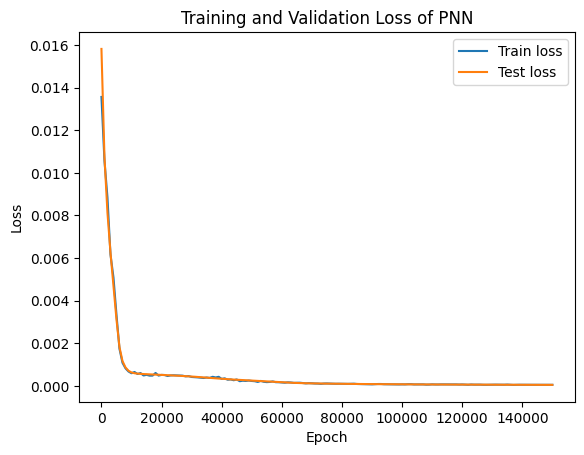

In [16]:
plt.plot(epochs_arr, train_losses, label="Train loss")
plt.plot(epochs_arr, test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss of PNN")
plt.legend()

In [17]:
model = torch.load('outputs/2025-05-14-12-53-37/model_best.pkl')

/var/folders/q7/wrtlvr8n71n1l0d6wm_ppynm0000gn/T/ipykernel_39507/381046712.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('outputs/2025-05-14-12-53-3

Make predictions:

In [18]:
test_inputs = data.X_test
test_targets = data.y_test.numpy()

model.eval()
with torch.no_grad():
    test_predictions = model(test_inputs).numpy()

assert len(test_inputs) == len(test_targets)

Text(0.5, 1.0, 'Trajectory of Particle Over Time')

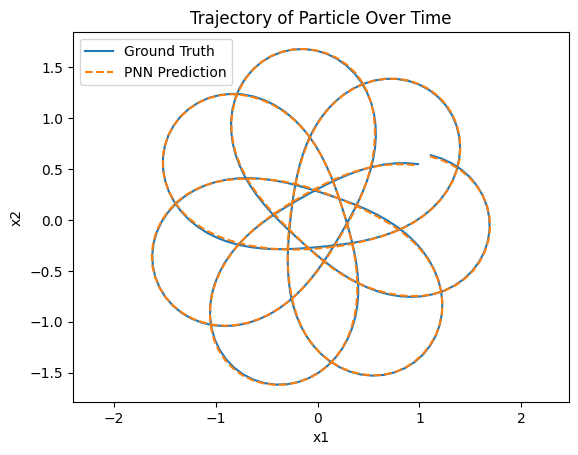

In [19]:
#split back into v1, v2, x1, x2
test_predictions_v = test_predictions[:, :2] #v1, v2
test_predictions_x = test_predictions[:, 2:] #x1, x2

test_targets_v = test_targets[:, :2] #v1, v2
test_targets_x = test_targets[:, 2:] #x1, x2

plt.plot(test_targets_x[:, 0], test_targets_x[:, 1], label="Ground Truth")
plt.plot(test_predictions_x[:, 0], test_predictions_x[:, 1], label="PNN Prediction", linestyle='--')
plt.legend()
plt.axis("equal")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Trajectory of Particle Over Time")

Visualize MSE/time:

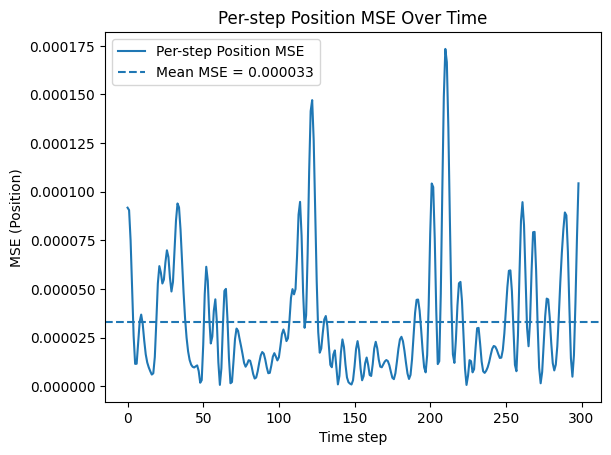

In [ ]:
mse_per_step_velocity = np.mean((test_targets[:, :2] - test_predictions[:, :2])**2, axis=1)
mse_per_step_position = np.mean((test_targets[:, 2:] - test_predictions[:, 2:])**2, axis=1)
tot_velocity_mse = np.mean(mse_per_step_velocity)
tot_position_mse = np.mean(mse_per_step_position)

plt.plot(np.arange(len(mse_per_step_position)), mse_per_step_position, label='Per-step Position MSE')
plt.axhline(y=tot_position_mse, linestyle='--', label=f'Mean MSE = {tot_position_mse:.6f}')
plt.xlabel('Time step')
plt.ylabel('MSE (Position)')
plt.title('Per-step Position MSE Over Time')
plt.legend()

loss_data = pd.DataFrame({
    "time_step": np.arange(len(mse_per_step_position)),
    "mse_per_step_position": mse_per_step_position,
})

loss_data.to_csv('mse_position_pnn.csv', index=False)